# TA後形状の予測

##### 作成日：　2024.12.9
##### データ元：　工程内形状データ、ライン作業実績
##### 解析手順：　データ抽出・前処理　⇒機械学習（ランダムフォレスト）⇒予測　⇒グラフ化

In [1]:
import sqlite3
import pandas as pd

# --------------------------------------------------------------
# 抽出対象
# --------------------------------------------------------------
user_code = "D250"
thickness = 30.0
width = 495


# --------------------------------------------------------------
# データベース接続＆抽出
# --------------------------------------------------------------
#dbname = "F:\\金属箔事業部\\秘L\\旧箔\\箔\\品質保証Gr\\QC150_品質データ\\010_オフライン形状測定装置データ_工場\\新形状測定装置\\★SQLite取り込みプログラム\\DB\\keijyo_new.db"
dbname = "./DB/keijyo_new.db"

# CASE WHEN THEN: 文字列の置換
# MAX : GROUP BY条件のなかで、m_timeの最大値を抽出

with sqlite3.connect(dbname) as conn1:
    sql = f'''
            SELECT
                * ,
                MAX(m_time),
                CASE 
                    WHEN position = 'f' THEN 'F'
                    WHEN position = 'Ｆ' THEN 'F'
                    WHEN position = 'b' THEN 'B'
                    WHEN position = 'Ｂ' THEN 'B'
                    ELSE position
                END AS new_position
            FROM tbl_01
            WHERE
                (customer = "{user_code}")
                AND (thickness = "{thickness}")
                AND (width = "{width}")
                AND (treat_code = "4" OR treat_code = "9")
            GROUP BY
                coil_num,
                coildiv_num,
                ope_code,
                treat_code,
                CASE 
                    WHEN position = 'f' THEN 'F'
                    WHEN position = 'Ｆ' THEN 'F'
                    WHEN position = 'b' THEN 'B'
                    WHEN position = 'Ｂ' THEN 'B'
                    ELSE position
                END
            ORDER BY m_date ASC
        '''
    df = pd.read_sql(sql, con=conn1)


# --------------------------------------------------------------
# DF作成
# --------------------------------------------------------------

# コイル番号
df["new_coil"] = df["coil_num"] + "-"+ df["coildiv_num"]

# 処理コードと位置の新規列　["9F","9B","4F","4B"] = ["FCR_F","FCR_B","TA_F","TA_B"]
df["process_position"] = df["treat_code"] + df["new_position"]

# 使用する列の指定
new_col = ["m_date", "new_coil", "process_position"] + [f"i{i}" for i in range(1, 21)]
df = df[new_col]

# CSV出力
#df.to_csv("data.csv", encoding='shift-jis')

df.head(3)

,m_date,new_coil,process_position,i1,i2,i3,i4,i5,i6,i7,...,i11,i12,i13,i14,i15,i16,i17,i18,i19,i20
0,2023-04-15 00:00:00,49134-11,9B,18.136928,3.790268,0.0,0.558058,0.992577,2.033761,2.587749,...,0.333904,0.013008,0.307649,0.652011,0.720563,1.595945,2.631035,4.617211,10.478505,17.890834
1,2023-04-15 00:00:00,49134-11,9F,14.397729,3.015333,0.0,0.479469,0.775821,1.638432,2.051087,...,0.772083,0.248304,0.395933,0.899396,0.736544,0.840219,1.414581,3.619171,8.066631,13.722709
2,2023-04-15 00:00:00,49134-12,9B,12.868052,4.347836,0.0,0.476016,1.263866,1.913309,2.823925,...,0.959822,0.789794,1.568435,1.387556,0.618093,0.651241,1.425827,2.963362,6.921700,10.121797


In [2]:
df_MF = df[df["process_position"] == "9F"]    # FCR F
df_MB = df[df["process_position"] == "9B"]    # FCR B
df_TF = df[df["process_position"] == "4F"]    # TA F
df_TB = df[df["process_position"] == "4B"]    # TA B

df_MF.columns = ["date_FCR_F", "new_coil", "pp_FCR_F"] + [f"FCR_F_{i}" for i in range(1, 21)]
df_MB.columns = ["date_FCR_B", "new_coil", "pp_FCR_B"] + [f"FCR_B_{i}" for i in range(1, 21)]
df_TF.columns = ["date_TA_F", "new_coil", "pp_TA_F"] + [f"TA_F_{i}" for i in range(1, 21)]
df_TB.columns = ["date_TA_B", "new_coil", "pp_TA_B"] + [f"TA_B_{i}" for i in range(1, 21)]

# "new_coil"をキーに各DFを結合
df2 = pd.merge(df_MF, df_MB, on="new_coil", how='left')
df2 = pd.merge(df2, df_TF, on="new_coil", how='left')
df2 = pd.merge(df2, df_TB, on="new_coil", how='left')

#df2.to_csv("data2.csv", encoding='shift-jis')

df2.head(3)

,date_FCR_F,new_coil,pp_FCR_F,FCR_F_1,FCR_F_2,FCR_F_3,FCR_F_4,FCR_F_5,FCR_F_6,FCR_F_7,...,TA_B_11,TA_B_12,TA_B_13,TA_B_14,TA_B_15,TA_B_16,TA_B_17,TA_B_18,TA_B_19,TA_B_20
0,2023-04-15 00:00:00,49134-11,9F,14.397729,3.015333,0.000000,0.479469,0.775821,1.638432,2.051087,...,2.006524,0.570906,0.501261,0.575592,0.108840,0.000000,1.169751,2.753668,7.081118,13.974039
1,2023-04-15 00:00:00,49134-12,9F,15.557247,4.253771,0.108134,0.819745,1.503837,1.987190,2.420420,...,1.252476,0.168589,0.007054,0.076176,0.000000,0.433399,1.830434,2.864033,6.868363,11.273258
2,2023-05-07 00:00:00,49135-1,9F,14.571781,5.226943,1.243542,1.725209,0.962206,0.626832,0.069162,...,2.305909,1.347314,0.940886,0.421182,0.235367,0.169316,1.139534,2.968099,7.583181,15.721907


### 熱処理条件
##### ライン作業実績のCSV読み込み

In [3]:
df_L1 = pd.read_csv("20241208_D30_TA.csv", encoding='shift-jis')
df_L1.head(3)

,協定仕様番号_需要家コード,協定仕様番号_品種コード,協定仕様番号_鋼種コード,協定仕様番号_調質コード,協定仕様番号_仕上コード,協定仕様番号_公称板厚,協定仕様番号_公称板幅,協定仕様番号_連番,協定仕様番号_改訂番号,コイル番号,...,熱処理_炉温7,熱処理_炉温8,熱処理_炉温9,熱処理_炉温10,熱処理_炉温11,熱処理_炉温12,熱処理_炉温13,熱処理_炉温14,熱処理_炉温15,熱処理_炉温16
0,D250,S,600,34,MW,300,4600,91,4,49134,...,644,654,508,401,292,302,213,201,103,20
1,D250,S,600,34,MW,300,4600,91,4,49134,...,643,654,506,406,292,302,210,204,83,16
2,D250,S,600,34,MW,300,4600,3,1,49135,...,643,655,488,401,292,302,218,206,93,18


In [4]:
# コイル番号
df_L1["new_coil"] = df_L1["コイル番号"].astype(str) + "-"+ df_L1["コイル分割番号"].astype(str)

# 文字列の左側から21文字を取り出して、日時型に変換し、新規列を作成
df_L1["TA_datetime"] = pd.to_datetime(df_L1["作業年月日時分"].astype(str).str[:12], format="%Y%m%d%H%M")

df_L2 = df_L1[["TA_datetime", "new_coil", "熱処理_速度"]]
df_L2.columns = ["TA_datetime", "new_coil", "TA_speed"]
df_L2.head(3)

,TA_datetime,new_coil,TA_speed
0,2023-04-15 20:15:00,49134-12,52.5
1,2023-04-22 05:11:00,49134-11,52.5
2,2023-05-11 05:57:00,49135-1,52.5


In [5]:
# "new_coil"をキーにDFを結合
df3 = pd.merge(df2, df_L2, on="new_coil", how='left')
df3 = df3.dropna(subset=["TA_B_1"])

df3.to_csv("data3.csv", encoding='shift-jis')
df3.head()

,date_FCR_F,new_coil,pp_FCR_F,FCR_F_1,FCR_F_2,FCR_F_3,FCR_F_4,FCR_F_5,FCR_F_6,FCR_F_7,...,TA_B_13,TA_B_14,TA_B_15,TA_B_16,TA_B_17,TA_B_18,TA_B_19,TA_B_20,TA_datetime,TA_speed
0,2023-04-15 00:00:00,49134-11,9F,14.397729,3.015333,0.000000,0.479469,0.775821,1.638432,2.051087,...,0.501261,0.575592,0.108840,0.000000,1.169751,2.753668,7.081118,13.974039,2023-04-22 05:11:00,52.5
1,2023-04-15 00:00:00,49134-12,9F,15.557247,4.253771,0.108134,0.819745,1.503837,1.987190,2.420420,...,0.007054,0.076176,0.000000,0.433399,1.830434,2.864033,6.868363,11.273258,2023-04-15 20:15:00,52.5
2,2023-05-07 00:00:00,49135-1,9F,14.571781,5.226943,1.243542,1.725209,0.962206,0.626832,0.069162,...,0.940886,0.421182,0.235367,0.169316,1.139534,2.968099,7.583181,15.721907,2023-05-11 05:57:00,52.5
4,2023-05-07 00:00:00,49137-1,9F,17.175607,5.213967,0.541531,1.152617,1.638883,2.704845,3.174399,...,1.136307,0.051831,0.000000,0.247982,1.788813,2.000866,4.791119,8.969177,2023-05-11 17:18:00,52.5
5,2023-05-08 00:00:00,49135-2,9F,15.934177,5.629736,0.732210,0.284865,0.213036,0.435435,0.621982,...,0.433087,0.045920,0.000000,0.653732,2.324486,3.572940,6.904149,11.017347,2023-05-11 09:13:00,52.5


In [6]:
# 予測用コイルのコイル番号取得
coil_research = input("予測するコイル番号を入力（ex. 53165-2）：")

# モデル作成＆テスト用データ（予測用データ除去）
df4 = df3.drop(df3[df3["new_coil"] == coil_research].index)

# 予測用データ
df4v = df3[df3["new_coil"]== coil_research]


予測するコイル番号を入力（ex. 53165-2）： 53475-1


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# 特徴量とターゲットの設定
X = df4[[f"FCR_F_{i}" for i in range(1, 21)] + ["TA_speed"]]   # プロセス前のデータ
y = df4[[f"TA_B_{i}" for i in range(1, 21)]]                   # プロセス後のデータ


# 学習関数
def learn(x, t, depth=3):
    # データの分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    model = RandomForestRegressor(n_estimators=100, random_state=0, max_depth = depth)
    model.fit(X_train, y_train)
    
    # モデル評価：MSE(Mean Squared Error)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return round(mse, 3), model


# ハイパーパラメータ最適化（MSEの最小値の探索）
min_mse = float('inf')
best_depth = None

for j in range(1, 15):
    mse, model = learn(X, y, depth = j)
    print(f"depth:{j}, MSE:{mse}")

    if mse < min_mse:
        min_mse = mse
        best_depth = j

print(f"The depth with the lowest MSE is: {best_depth}")

depth:1, MSE:2.112
depth:2, MSE:1.989
depth:3, MSE:1.94
depth:4, MSE:1.903
depth:5, MSE:1.902
depth:6, MSE:1.904
depth:7, MSE:1.916
depth:8, MSE:1.86
depth:9, MSE:1.912
depth:10, MSE:1.912
depth:11, MSE:1.883
depth:12, MSE:1.888
depth:13, MSE:1.887
depth:14, MSE:1.886
The depth with the lowest MSE is: 8


In [8]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# モデル適用（max_depthは上記の最小値を代入）
model = RandomForestRegressor(n_estimators=100, random_state=0, max_depth = best_depth)
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=8, random_state=0)

In [9]:
# 予測用データのインデックスを取得
index_reserch = df4v[df4v["new_coil"] == coil_research].index[0]

# 予測用データをDF化
df4v_F1 = pd.concat([df4v.loc[index_reserch, "FCR_F_1":"FCR_F_20"], pd.Series(df4v.loc[index_reserch, "TA_speed"], index=["TA_speed"])])
df4vd_F1 = pd.DataFrame([df4v_F1])

# 予測結果
predicted = model.predict(df4vd_F1)

df5_TA_B_predicted = pd.DataFrame(predicted)
df5_TA_B_predicted = df5_TA_B_predicted.rename(index={0: 'TA_B_predicted'})
df5_TA_B_predicted

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
TA_B_predicted,15.3149,3.502453,0.203597,0.275152,0.499838,1.448879,2.038409,3.274891,3.021693,3.272583,2.543298,1.7656,1.447765,0.333589,0.234394,0.266606,1.397509,3.179515,7.748907,14.811607


In [10]:
# FCR_F：入力データ
Li5_FCR_F = df3.loc[index_reserch, "FCR_F_1":"FCR_F_20"]
df5_FCR_F = pd.DataFrame([Li5_FCR_F])
df5_FCR_F = df5_FCR_F.reset_index(drop=True).rename({0: "FCR_F"})
df5_FCR_F.columns = [ i for i in range(0, 20)]

# TA_B：実際のデータ
Li5_TA_B_actual = df3.loc[index_reserch, "TA_B_1":"TA_B_20"]
df5_TA_B_actual = pd.DataFrame([Li5_TA_B_actual])
df5_TA_B_actual = df5_TA_B_actual.reset_index(drop=True).rename({0: "TA_B_actual"})
df5_TA_B_actual.columns = [ i for i in range(0, 20)]

# データフレームを結合
df6 = pd.concat([df5_FCR_F, df5_TA_B_actual, df5_TA_B_predicted])
df6

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
FCR_F,17.318990,4.726817,0.000000,1.080382,1.756644,3.554322,2.213700,1.918036,1.885267,1.981243,0.624567,0.273147,1.249357,1.440174,0.824112,0.144186,2.580405,5.670945,12.163835,16.420921
TA_B_actual,15.212827,3.982983,0.112934,0.000000,0.373210,1.648439,2.143780,2.800879,3.199854,4.064080,3.326878,0.991173,0.539985,0.223377,0.035630,0.389223,3.186922,5.392824,11.097629,18.879041
TA_B_predicted,15.314900,3.502453,0.203597,0.275152,0.499838,1.448879,2.038409,3.274891,3.021693,3.272583,2.543298,1.765600,1.447765,0.333589,0.234394,0.266606,1.397509,3.179515,7.748907,14.811607


### グラフ描画

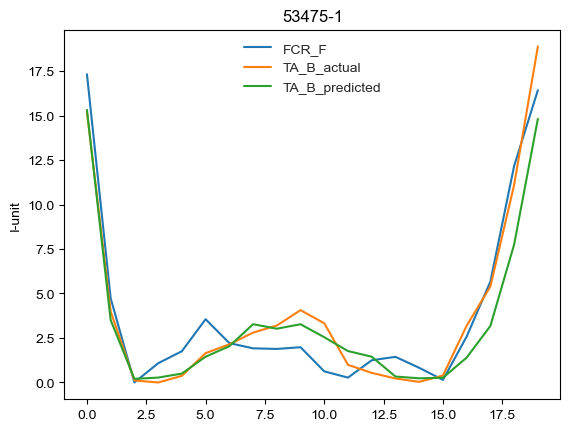

In [11]:
import matplotlib.pyplot as plt
import math
%matplotlib inline

fig, ax = plt.subplots()

# グリッドのスタイルを指定
plt.style.use('seaborn-v0_8-whitegrid')

# グラフ描画
for i in range(len(df6.index)):
    
    x  = df6.columns
    y  = df6.iloc[i]

    ax.plot(x, y, label = df6.index[i])
    ax.set_ylabel("I-unit")
    ax.set_title(coil_research) 
    ax.legend(loc=0)

# グラフ保存・表示    
plt.savefig(f"{coil_research}.png")
plt.show()